Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

In [5]:
set_seed(455)
np.random.seed(455)

We import the MasterCard dataset by adding the Date column to the index and converting it to DateTime format.Drop irrelevant columns from the dataset.We are interested in stock prices, volume, and date.
The dataset has Date as index and Open, High, Low, Close, and Volume as columns. 

In [6]:
dataset = pd.read_csv("/content/Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]
).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


The .describe() function helps us analyze the data in depth. We take High column as we are going to use it to train the model. We can also choose Close or Open columns for a model feature, but High makes more sense as it provides us information of how high the values of the share went on the given day.The minimum stock price is $4.10, and the highest is $400.5. The mean is at $105.9 and the standard deviation $107.3, which means that stocks have high variance.

In [7]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


By using .isna().sum() we can determine the missing values in the dataset. It seems that the dataset has no missing values.

In [8]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

The train_test_plot function takes three arguments: dataset, tstart, and tend and plots a simple line graph. The tstart and tend are time limits in years. We can change these arguments to analyze specific periods. The line plot is divided into two parts: train and test. This will allow us to decide the distribution of the test dataset.
MasterCard stock prices have been on the rise since 2016. It had a dip in the first quarter of 2020 but it gained a stable position in the latter half of the year. Our test dataset consists of one year, from 2021 to 2022, and the rest of the dataset is used for training.

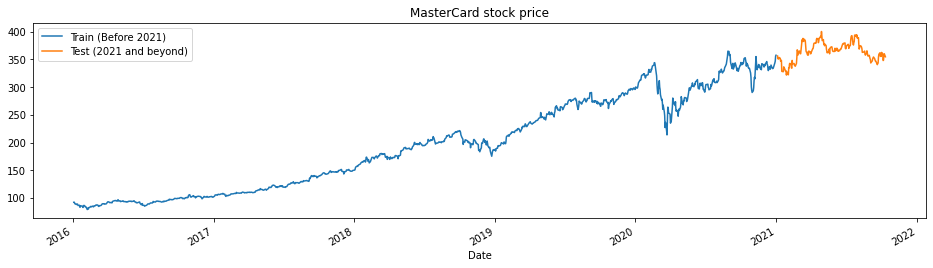

In [9]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)


#Data Preprocessing

The train_test_split function divides the dataset into two subsets: training_set and test_set.

In [10]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)


We use the MinMaxScaler function to standardize our training set that avoids the outliers or anomalies.Can try using StandardScaler to normalize your data and improve model performance.

In [11]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

The split_sequence function uses a training dataset and converts it into inputs (X_train) and outputs (y_train).In this project, we are using 60 n_steps. We can also reduce or increase the number of steps to optimize model performance.

In [12]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)


We are working with univariate series, so the number of features is one, and we need to reshape the X_train to fit on the LSTM model. The X_train has [samples, timesteps], and we will reshape it to [samples, timesteps, features].

In [13]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

#LSTM Model

The model consists of a single hidden layer of LSTM and an output layer.We will set LSTM units to 125, tanh as activation, and set input size.

In [14]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


The model will train on 50 epochs with 32 batch sizes. You can change the hyperparameters to reduce training time or improve the results. The model training was successfully completed with the best possible loss.

In [15]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 5s 63ms/step - loss: 0.0142
Epoch 2/50
38/38 [==============================] - 2s 62ms/step - loss: 0.0027
Epoch 3/50
38/38 [==============================] - 2s 63ms/step - loss: 0.0020
Epoch 4/50
38/38 [==============================] - 2s 63ms/step - loss: 0.0019
Epoch 5/50
38/38 [==============================] - 2s 62ms/step - loss: 0.0014
Epoch 6/50
38/38 [==============================] - 2s 63ms/step - loss: 0.0015
Epoch 7/50
38/38 [==============================] - 4s 95ms/step - loss: 9.8822e-04
Epoch 8/50
38/38 [==============================] - 2s 62ms/step - loss: 0.0012
Epoch 9/50
38/38 [==============================] - 2s 62ms/step - loss: 9.5300e-04
Epoch 10/50
38/38 [==============================] - 2s 63ms/step - loss: 0.0011
Epoch 11/50
38/38 [==============================] - 2s 63ms/step - loss: 8.7355e-04
Epoch 12/50
38/38 [==============================] - 2s 63ms/step - loss: 8.3610e-04
Epoch 13/50
38/38 [==

We repeat preprocessing and normalize the test set. First of all we will transform then split the dataset into samples, reshape it, predict, and inverse transform the predictions into standard form.

In [16]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 [==============================] - 1s 25ms/step


The plot_predictions function will plot a real versus predicted line chart. This will help us visualize the difference between actual and predicted values.

The return_rmse function takes in test and predicted arguments and prints out the root mean square error (rmse) metric.

In [17]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

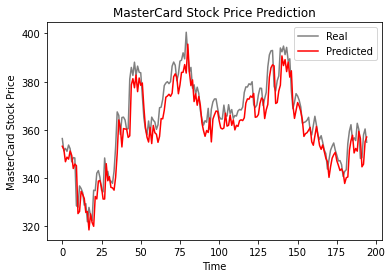

In [18]:
plot_predictions(test_set,predicted_stock_price)

In [19]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 6.70.


#GRU Model

Just replace the LSTM layer with the GRU layer to properly compare the results. The model structure contains a single GRU layer with 125 units and an output layer.

In [20]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 4s 49ms/step - loss: 0.0192
Epoch 2/50
38/38 [==============================] - 2s 48ms/step - loss: 0.0021
Epoch 3/50
38/38 [==============================] - 2s 48ms/step - loss: 0.0016
Epoch 4/50
38/38 [==============================] - 2s 48ms/step - loss: 0.0013
Epoch 5/50
38/38 [==============================] - 2s 47ms/step - loss: 9.1870e-04
Epoch 6/50
38/38 [==============================] - 2s 49ms/step - loss: 9.9658e-04
Epoch 7/50
38/38 [==============================] - 2s 47ms/step - loss: 6.7015e-04
Epoch 8/50
38/38 [==============================] - 2s 47ms/step - loss: 7.6807e-04
Epoch 9/50
38/38 [==============================] - 2s 60ms/step - loss: 6.7032e-04
Epoch 10/50
38/38 [==============================] - 2s 53ms/step - loss: 7.1882e-04
Epoch 11/50
38/38 [==============================] - 2s 60ms/step - loss: 5.9915e-04
Epoch 12/50
38/38 [==============================] - 2s 48ms/step - loss: 5.4595e-04
Epoch

The real and predicted values are relatively close. The predicted line chart almost fits the actual values.

7/7 [==============================] - 0s 14ms/step


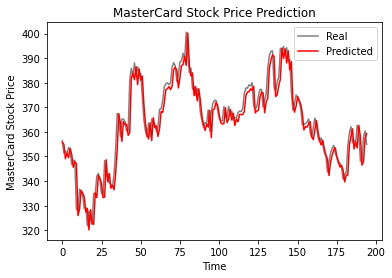

In [22]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

GRU model got 5.50 rmse on the test dataset, which is an improvement from the LSTM model.

In [23]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.41.


The results clearly show that the GRU model performed better than LSTM, with a similar structure and hyperparameters.